## QF607 Numerical Methods - Assignment 1
### Anirban Chakraborty; 01436632; anirbanc.2021@mqf.smu.edu.sg

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from enum import Enum
import math
from copy import deepcopy

1. Implement a function that converts a ```fixed<w, b>``` representation to a real number. Use two's compement for negative numbers. The function signature is 

   ```python
   def fromFixedPoint(w: int, b:int, bits:[int]) -> float:
   # w: width of the binary representation
   # b: binary point
   ```
   Test the following inputs
   ```python
   fromFixedPoint(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0])
   ```
   ```python
   fromFixedPoint(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1])
   ```
   ```python
   fromFixedPoint(8, 2, [1, 0, 1, 0, 1, 0, 1, 1])
   ```
   


In [70]:
def fromFixedPoint(w: int, b:int, bits:[int]) -> float:
    a = 0
    #Negative Part
    a = -bits[0]*2**(w-1-b)
    #Float Part
    for i in range(0, w-1):
        a = a + bits[w-1-i]*2**(i-b)
        #print("Loop: i = ", i, "     bi=", bits[w-1-i], "    2expp = ", (i-b), "     a =", a, "     x =", bits[w-1-i]*2**(i-b))
    return a
    

In [71]:
fromFixedPoint(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0])

44.75

In [72]:
fromFixedPoint(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1])

-13.28125

In [73]:
fromFixedPoint(8, 2, [1, 0, 1, 0, 1, 0, 1, 1])

-21.25

2. Calculate the price of the following questions step by step using two step Cox Rox Rubinstein (CRR) Binomial tree

    a. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$
    
    b. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$
    
    c. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$
    
    d. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$
    
    What is the value of the portfolio that is long (a) and short (b)? How about the portfolio that long (c) and short (d)?
    

In [6]:
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'

class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return continuation

class AmericanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

In [7]:
def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

In [8]:
def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

Value of a European call option with  𝑆=100 ,  𝐾=105 ,  𝑟=3% ,  𝑇=1 ,  𝜎=20%

In [9]:
binomialPricer(S = 100, r = 0.03, vol = 0.2, trade = EuropeanOption(1, 105, PayoffType.Call), n = 300, calib = crrCalib)

7.1271625563823005

Value of a European put option with  𝑆=100 ,  𝐾=105 ,  𝑟=3% ,  𝑇=1 ,  𝜎=20%

In [10]:
binomialPricer(S = 100, r = 0.03, vol = 0.2, trade = EuropeanOption(1, 105, PayoffType.Put), n = 300, calib = crrCalib)

9.023943578974393

Value of a European call option with  𝑆=100 ,  𝐾=105 ,  𝑟=3% ,  𝑇=1 ,  𝜎=10% 

In [11]:
binomialPricer(S = 100, r = 0.03, vol = 0.1, trade = EuropeanOption(1, 105, PayoffType.Call), n = 300, calib = crrCalib)

3.1491973665986186

Value of a European put option with  𝑆=100 ,  𝐾=105 ,  𝑟=3% ,  𝑇=1 ,  𝜎=10%

In [12]:
binomialPricer(S = 100, r = 0.03, vol = 0.1, trade = EuropeanOption(1, 105, PayoffType.Put), n = 300, calib = crrCalib)

5.04597838919069

Value of the portfolio that is long (a) and short (b)

In [76]:
abs(binomialPricer(S = 100, r = 0.03, vol = 0.2, trade = EuropeanOption(1, 105, PayoffType.Call), n = 300, calib = crrCalib) - binomialPricer(S = 100, r = 0.03, vol = 0.2, trade = EuropeanOption(1, 105, PayoffType.Put), n = 300, calib = crrCalib))

1.8967810225920925

Value of the portfolio that is long (c) and short (d)

In [77]:
abs(binomialPricer(S = 100, r = 0.03, vol = 0.1, trade = EuropeanOption(1, 105, PayoffType.Call), n = 300, calib = crrCalib) - binomialPricer(S = 100, r = 0.03, vol = 0.1, trade = EuropeanOption(1, 105, PayoffType.Put), n = 300, calib = crrCalib))

1.8967810225920716

3. Greeks measure the sensitivity of the price of derivatives to a change in underlying asset’s parameters. They are used for hedging and risk
management. The commonly used greeks are:
    * Delta $\Delta = \frac{\partial V}{\partial S}$: measures the rate of change of the option value with respect to changes in the underlying asset's price.
    * Gamma $\Gamma = \frac{\partial^2 V}{\partial S^2} = \frac{\partial \Delta}{\partial S}$: measures the rate of change of delta with respect to changes in the underlying asset's price.
    * Vega: $v = \frac{\partial V}{\partial \sigma}$: measures the rate of change of the option value with respect to changes in the underlying asset's volatility.
    * Theta: $\theta = \frac{\partial V}{\partial t}$: the rate of change in the price of an option with respect to pricing time. Note that we normally use $t$ to represent pricing time, $T$ to represent expiry time, time to expiry in our pricer is $T-t$. In the implementation of the pricers that take time to expiry as an argument, we implicitly set pricing time to 0 (present).
    * Rho (PV01): the rate of change in the price of an option in response to a change in the interest rate.
    
  The greeks are normally not known in closed form since numerical pricers are used. They are approximated by finite differences:

    \begin{align}
    & \Delta = \frac{\partial V}{\partial S} \approx \frac{V(S + \Delta S) - V(S-\Delta S)}{2 \Delta S}, ~~~\Delta S = 0.1\% S \\
    & \Gamma = \frac{\partial V^2}{\partial S^2} \approx \frac{V(S + \Delta S) - 2V(S) + V(S-\Delta S)}{\Delta S^2} \\
    & v = \frac{\partial V}{\partial \sigma} \approx \frac{V(S, \sigma +\Delta \sigma) - V(S, \sigma -\Delta \sigma)}{2 \Delta \sigma } ~~~~~~~\Delta \sigma = 0.1\% \\
    & \theta = \frac{\partial V}{\partial t} \approx \frac{V(S, t+\Delta t, T) - V(S, t, T)}{\Delta t} ~~~~\Delta t = 0.004 \\
    & \text{PV01} = \frac{\partial V}{\partial r} \approx \frac{V(S, r+\Delta r) - V(S, r - \Delta r)}{2 \Delta r}  ~~~~~\Delta r = 0.0001
    \end{align}

  Implement a Greeks calculater for binomial tree pricer provided below. The signature of the greeks calculator is
      ```python
      def binomialGreeks(S, r, vol, T, strike, greekType) -> float
      ```
  Setting $S = 100, r = 0.03, vol = 0.2, t = 0, T = 1$, plot each greeks as a function of strike from 50 to 150. Play with different binomial models and see if there is any difference.
  
  Note that in practice, the greeks are rescaled with a pre-defined scaler, so that they give a sense of how much PV (Delta) changes with a typical move of the market. The rescaling is not incorporated in this exercise.

In [15]:
def binomialGreeks(S, r, vol, trade, calib=crrCalib):
    n = 500
    del_S = 0.001*S
    del_vol = 0.001
    del_t = 0.004
    del_r = 0.0001
    delta = (binomialPricer(S + del_S, r, vol, trade, n, calib) - 
             binomialPricer(S - del_S, r, vol, trade, n, calib))/(2*del_S)
    gamma = (binomialPricer(S + del_S, r, vol, trade, n, calib) -
             2*binomialPricer(S, r, vol, trade, n, calib) +
             binomialPricer(S - del_S, r, vol, trade, n, calib))/(del_S**2)
    vega = (binomialPricer(S, r, vol + del_vol, trade, n, calib) - 
             binomialPricer(S, r, vol - del_vol, trade, n, calib))/(2*del_vol)
    pv01 = (binomialPricer(S, r + del_r, vol, trade, n, calib) - 
             binomialPricer(S, r - del_r, vol, trade, n, calib))/(2*del_r) 
    trade2 = deepcopy(trade)
    trade2.expiry = trade.expiry - del_t
    theta = (binomialPricer(S, r , vol, trade2, n, calib) - 
             binomialPricer(S, r , vol, trade, n, calib))/(del_t)
    return delta, gamma, theta, vega, pv01

In [16]:
strikes = range(50,150,1)

### European Call Greeks

In [17]:
delta, gamma, theta, vega, pv01 = [], [], [], [], []
for i in strikes:
    delta1, gamma1, theta1, vega1, pv011 = binomialGreeks(100, 0.03, 0.2, EuropeanOption(1, i, PayoffType.Call), crrCalib)
    delta.append(delta1)
    gamma.append(gamma1)
    vega.append(vega1)
    theta.append(theta1)
    pv01.append(pv011)

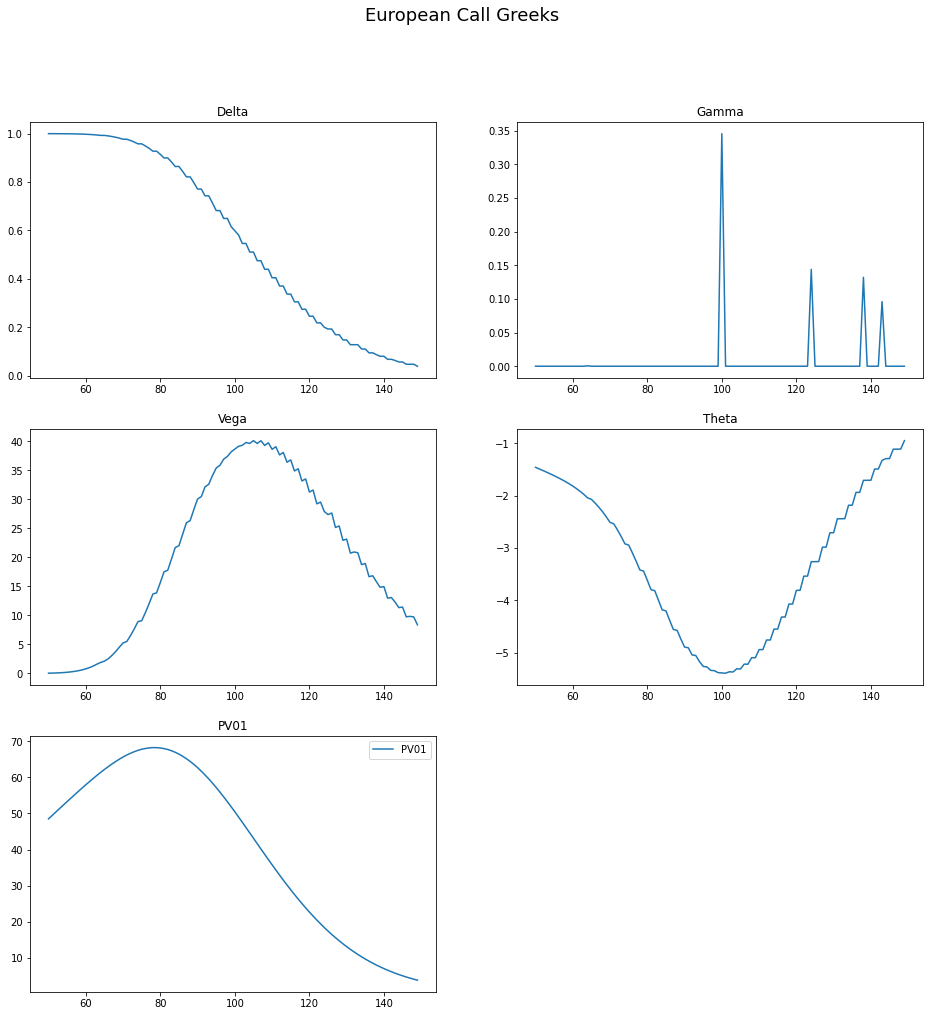

In [18]:
plt.figure(figsize = (16,16))
plt.subplot(3, 2, 1)
plt.plot(strikes,delta, label = 'Delta')
plt.title("Delta")

plt.subplot(3, 2, 2)
plt.plot(strikes,gamma, label = 'Gamma')
plt.title("Gamma")

plt.subplot(3, 2, 3)
plt.plot(strikes,vega, label = 'Vega')
plt.title("Vega")

plt.subplot(3, 2, 4)
plt.plot(strikes,theta, label = 'Theta')
plt.title("Theta")

plt.subplot(3, 2, 5)
plt.plot(strikes,pv01, label = 'PV01')
plt.title("PV01")

plt.suptitle('European Call Greeks', fontsize=18)
plt.legend()
plt.show()

### European Put Greeks

In [19]:
delta, gamma, theta, vega, pv01 = [], [], [], [], []
for i in strikes:
    delta1, gamma1, theta1, vega1, pv011 = binomialGreeks(100, 0.03, 0.2, EuropeanOption(1, i, PayoffType.Put), crrCalib)
    delta.append(delta1)
    gamma.append(gamma1)
    vega.append(vega1)
    theta.append(theta1)
    pv01.append(pv011)

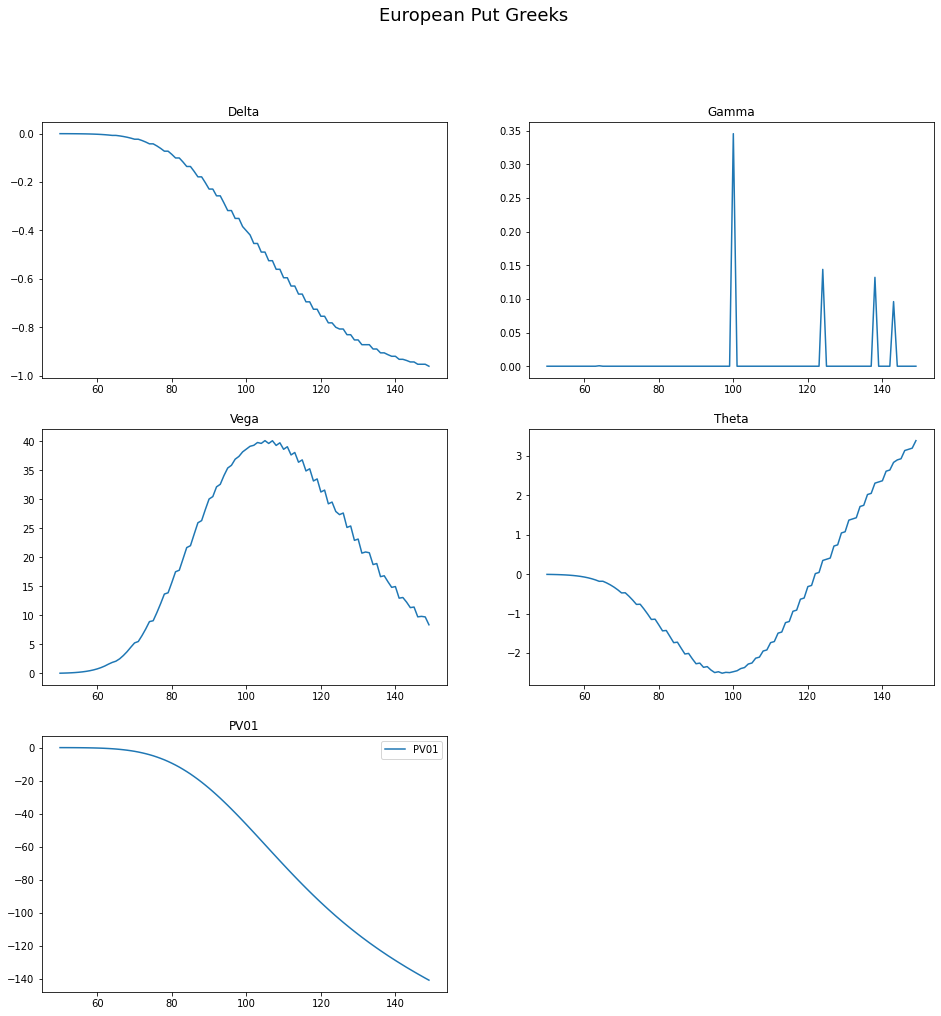

In [20]:
plt.figure(figsize = (16,16))
plt.subplot(3, 2, 1)
plt.plot(strikes,delta, label = 'Delta')
plt.title("Delta")

plt.subplot(3, 2, 2)
plt.plot(strikes,gamma, label = 'Gamma')
plt.title("Gamma")

plt.subplot(3, 2, 3)
plt.plot(strikes,vega, label = 'Vega')
plt.title("Vega")

plt.subplot(3, 2, 4)
plt.plot(strikes,theta, label = 'Theta')
plt.title("Theta")

plt.subplot(3, 2, 5)
plt.plot(strikes,pv01, label = 'PV01')
plt.title("PV01")

plt.suptitle('European Put Greeks', fontsize=18)
plt.legend()
plt.show()

### American Call Greeks

In [21]:
delta, gamma, theta, vega, pv01 = [], [], [], [], []
for i in strikes:
    delta1, gamma1, theta1, vega1, pv011 = binomialGreeks(100, 0.03, 0.2, AmericanOption(1, i, PayoffType.Call), crrCalib)
    delta.append(delta1)
    gamma.append(gamma1)
    vega.append(vega1)
    theta.append(theta1)
    pv01.append(pv011)

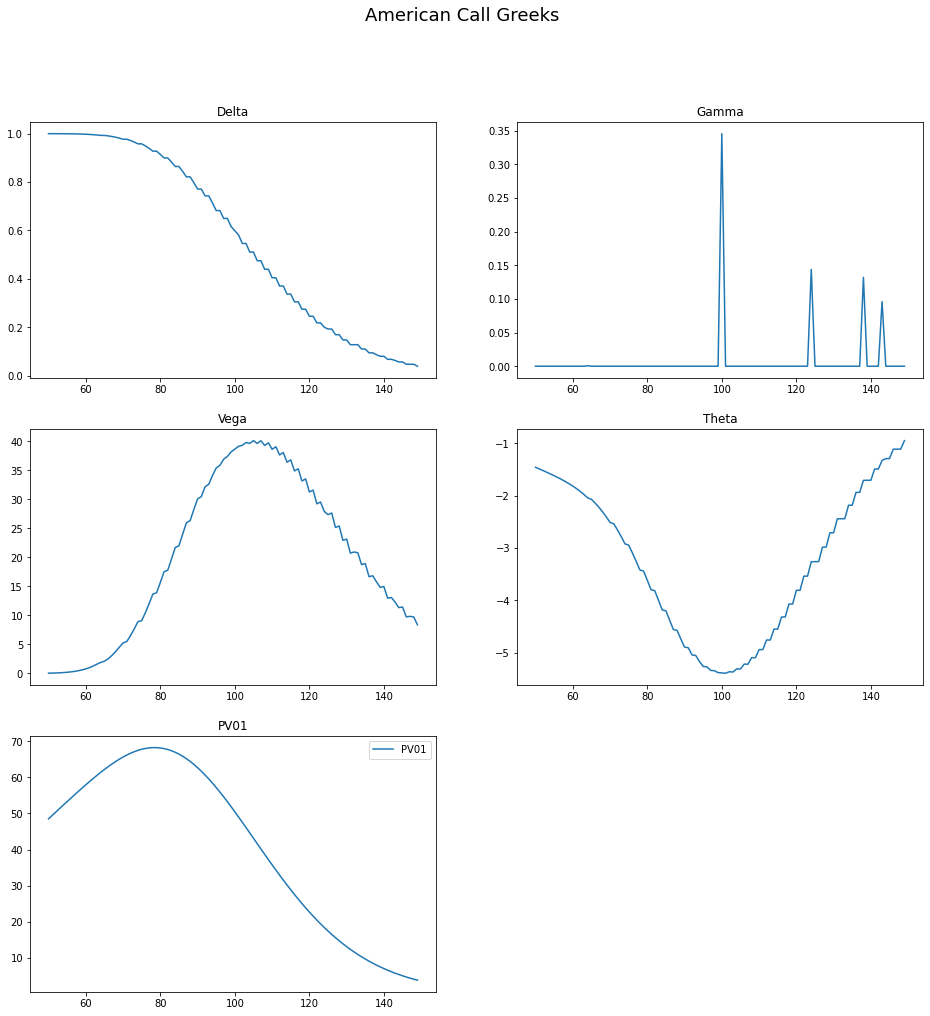

In [22]:
plt.figure(figsize = (16,16))
plt.subplot(3, 2, 1)
plt.plot(strikes,delta, label = 'Delta')
plt.title("Delta")

plt.subplot(3, 2, 2)
plt.plot(strikes,gamma, label = 'Gamma')
plt.title("Gamma")

plt.subplot(3, 2, 3)
plt.plot(strikes,vega, label = 'Vega')
plt.title("Vega")

plt.subplot(3, 2, 4)
plt.plot(strikes,theta, label = 'Theta')
plt.title("Theta")

plt.subplot(3, 2, 5)
plt.plot(strikes,pv01, label = 'PV01')
plt.title("PV01")

plt.suptitle('American Call Greeks', fontsize=18)
plt.legend()
plt.show()

### American Put Greeks

In [23]:
delta, gamma, theta, vega, pv01 = [], [], [], [], []
for i in strikes:
    delta1, gamma1, theta1, vega1, pv011 = binomialGreeks(100, 0.03, 0.2, AmericanOption(1, i, PayoffType.Put), crrCalib)
    delta.append(delta1)
    gamma.append(gamma1)
    vega.append(vega1)
    theta.append(theta1)
    pv01.append(pv011)

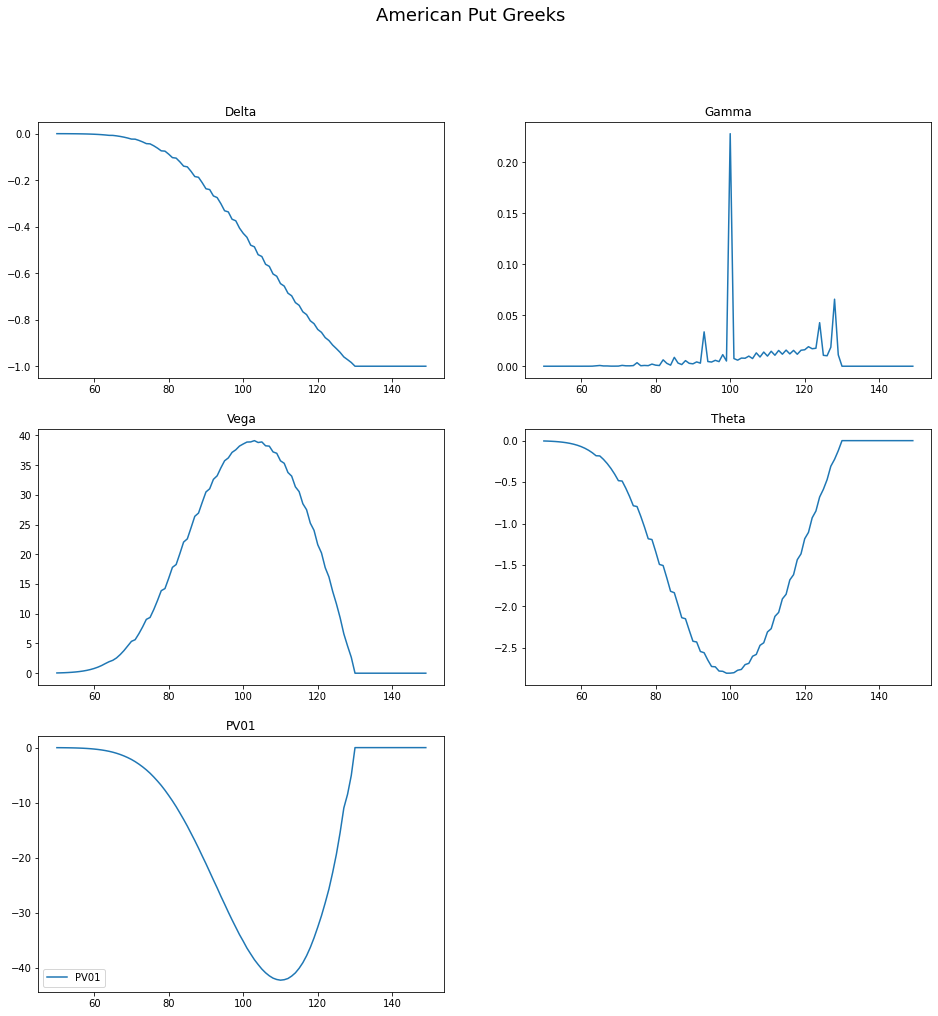

In [24]:
plt.figure(figsize = (16,16))
plt.subplot(3, 2, 1)
plt.plot(strikes,delta, label = 'Delta')
plt.title("Delta")

plt.subplot(3, 2, 2)
plt.plot(strikes,gamma, label = 'Gamma')
plt.title("Gamma")

plt.subplot(3, 2, 3)
plt.plot(strikes,vega, label = 'Vega')
plt.title("Vega")

plt.subplot(3, 2, 4)
plt.plot(strikes,theta, label = 'Theta')
plt.title("Theta")

plt.subplot(3, 2, 5)
plt.plot(strikes,pv01, label = 'PV01')
plt.title("PV01")

plt.suptitle('American Put Greeks', fontsize=18)
plt.legend()
plt.show()

### European Call Greeks - Model Comparisons

In [25]:
models = [crrCalib, jrrnCalib, jreqCalib, tianCalib]
modelname = ["crrCalib", "jrrnCalib", "jreqCalib", "tianCalib"]

In [26]:
for j in range(len(models)):
    delta, gamma, theta, vega, pv01 = [], [], [], [], []
    for i in strikes:
        delta1, gamma1, theta1, vega1, pv011 = binomialGreeks(100, 0.03, 0.2, EuropeanOption(1, i, PayoffType.Call), models[j])
        delta.append(delta1)
        gamma.append(gamma1)
        vega.append(vega1)
        theta.append(theta1)
        pv01.append(pv011)
    exec(f"delta{modelname[j]} = delta.copy()")
    exec(f"gamma{modelname[j]} = gamma.copy()")
    exec(f"theta{modelname[j]} = theta.copy()")
    exec(f"vega{modelname[j]} = vega.copy()")
    exec(f"pv01{modelname[j]} = pv01.copy()")    

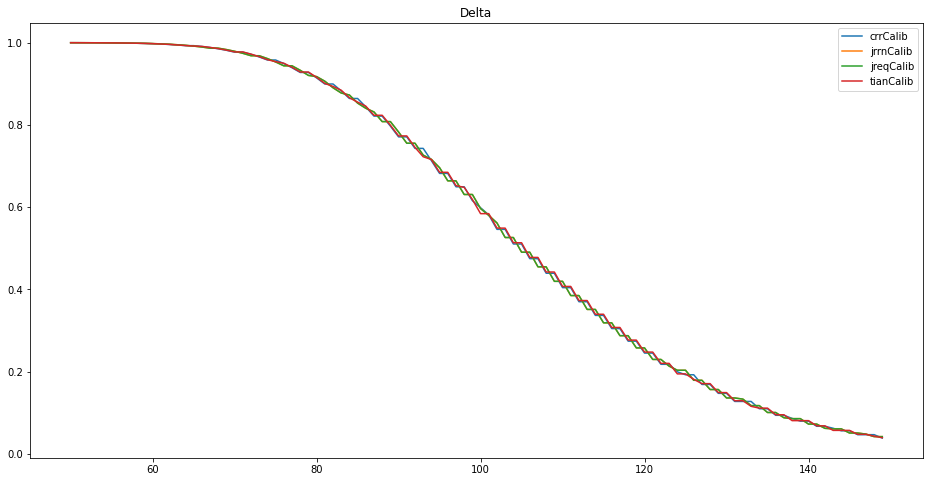

In [27]:
plt.figure(figsize = (16,8))
plt.plot(strikes,deltacrrCalib, label = modelname[0])
plt.plot(strikes,deltajrrnCalib, label = modelname[1])
plt.plot(strikes,deltajreqCalib, label = modelname[2])
plt.plot(strikes,deltatianCalib, label = modelname[3])
plt.title("Delta")
plt.legend()
plt.show()

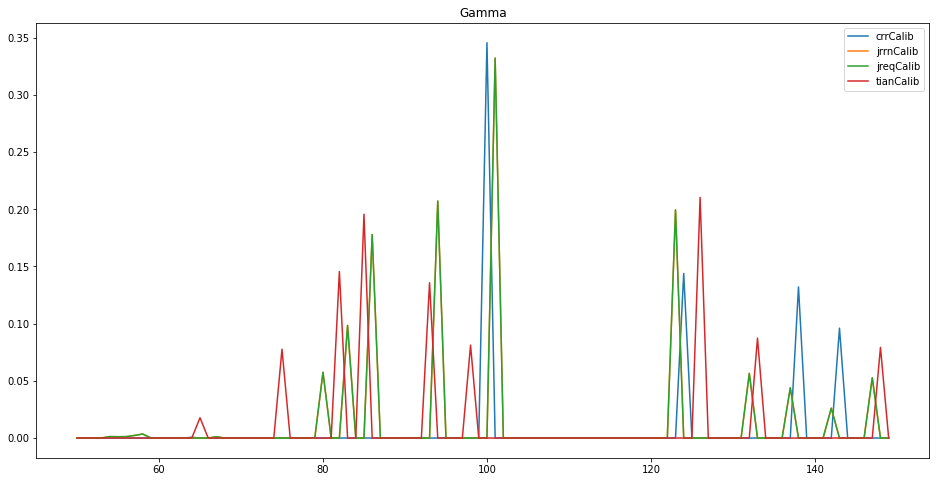

In [28]:
plt.figure(figsize = (16,8))
plt.plot(strikes,gammacrrCalib, label = modelname[0])
plt.plot(strikes,gammajrrnCalib, label = modelname[1])
plt.plot(strikes,gammajreqCalib, label = modelname[2])
plt.plot(strikes,gammatianCalib, label = modelname[3])
plt.title("Gamma")
plt.legend()
plt.show()

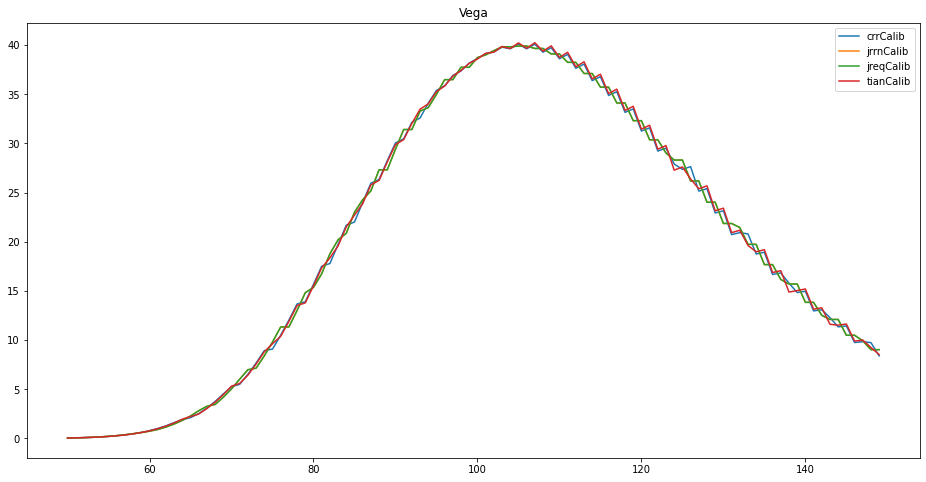

In [29]:
plt.figure(figsize = (16,8))
plt.plot(strikes,vegacrrCalib, label = modelname[0])
plt.plot(strikes,vegajrrnCalib, label = modelname[1])
plt.plot(strikes,vegajreqCalib, label = modelname[2])
plt.plot(strikes,vegatianCalib, label = modelname[3])
plt.title("Vega")
plt.legend()
plt.show()

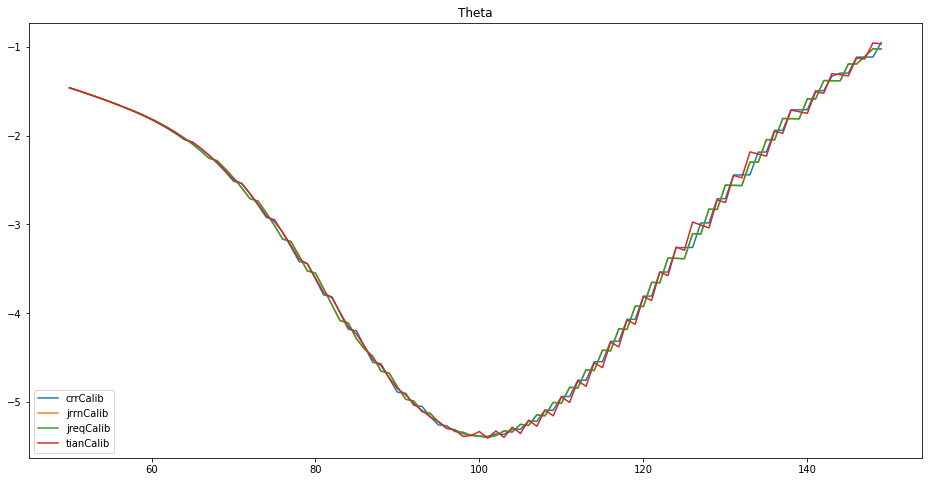

In [30]:
plt.figure(figsize = (16,8))
plt.plot(strikes,thetacrrCalib, label = modelname[0])
plt.plot(strikes,thetajrrnCalib, label = modelname[1])
plt.plot(strikes,thetajreqCalib, label = modelname[2])
plt.plot(strikes,thetatianCalib, label = modelname[3])
plt.title("Theta")
plt.legend()
plt.show()

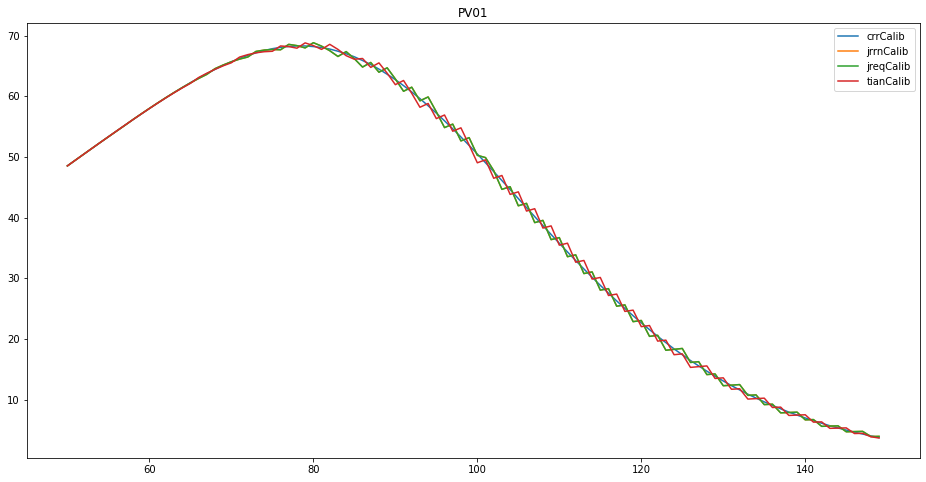

In [31]:
plt.figure(figsize = (16,8))
plt.plot(strikes,pv01crrCalib, label = modelname[0])
plt.plot(strikes,pv01jrrnCalib, label = modelname[1])
plt.plot(strikes,pv01jreqCalib, label = modelname[2])
plt.plot(strikes,pv01tianCalib, label = modelname[3])
plt.title("PV01")
plt.legend()
plt.show()